#### 1. Preprocessing ####

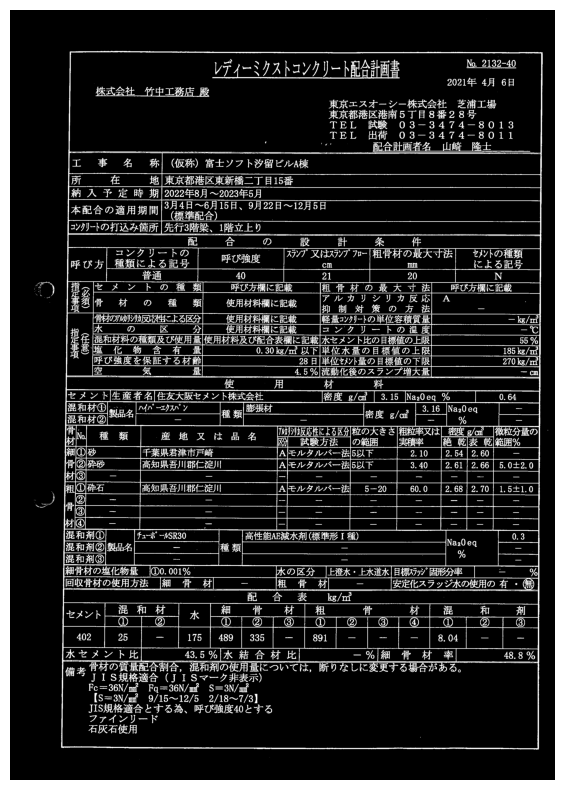

In [1]:
import cv2
import matplotlib.pyplot as plt

# Đọc ảnh
image = cv2.imread('image/image_table_test2.jpg')

# Chuyển ảnh sang xám
image_pre = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Thresholding
_, image_pre = cv2.threshold(image_pre, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Inverting
image_pre = cv2.bitwise_not(image_pre)

# Dilation
# image_pre = cv2.dilate(image_pre, None, iterations=1)

plt.figure(figsize = (30,10))
plt.imshow(image_pre, cmap='gray')
plt.axis("off")
plt.show()

(-0.5, 2482.5, 3510.5, -0.5)

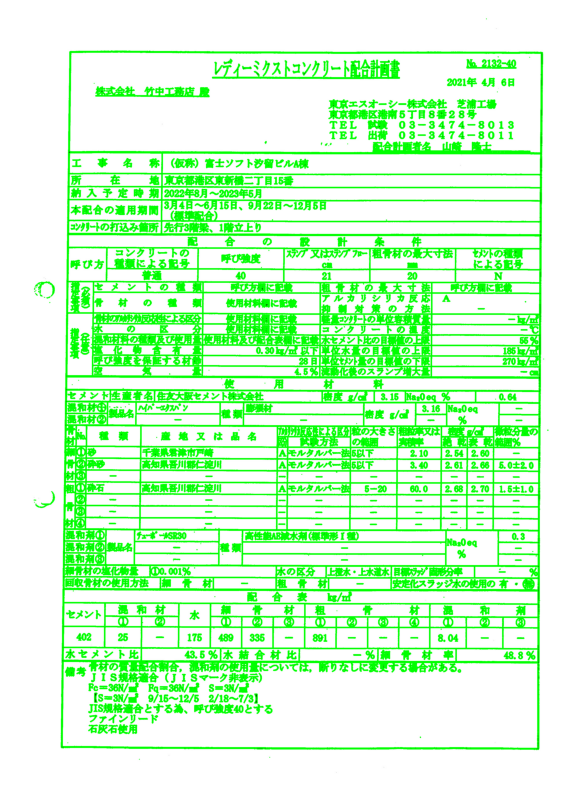

In [2]:
contours, hierarchy = cv2.findContours(image_pre, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contour = image.copy()
cv2.drawContours(image_with_contour, contours, -1, (0, 255, 0), 3)
plt.figure(figsize = (30,10))
plt.imshow(image_with_contour, cmap='gray')
plt.axis('off')

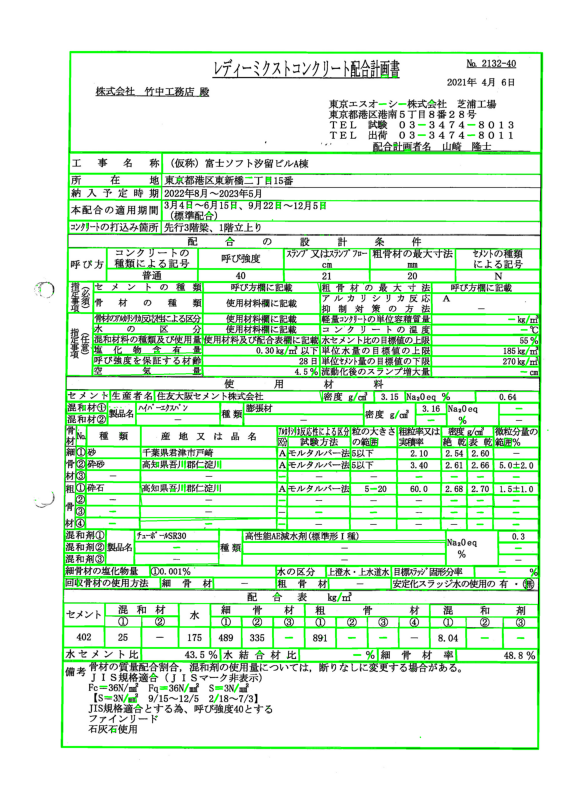

In [3]:
rectangular_contours = []
for contour in contours:
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
    if len(approx) == 4:
        rectangular_contours.append(approx)
   
image_with_rectangle_contour = image.copy()
cv2.drawContours(image_with_rectangle_contour, rectangular_contours, -1, (0, 255, 0), 3)
plt.figure(figsize = (30,10))
plt.imshow(image_with_rectangle_contour, cmap='gray')
plt.axis('off')
plt.show()

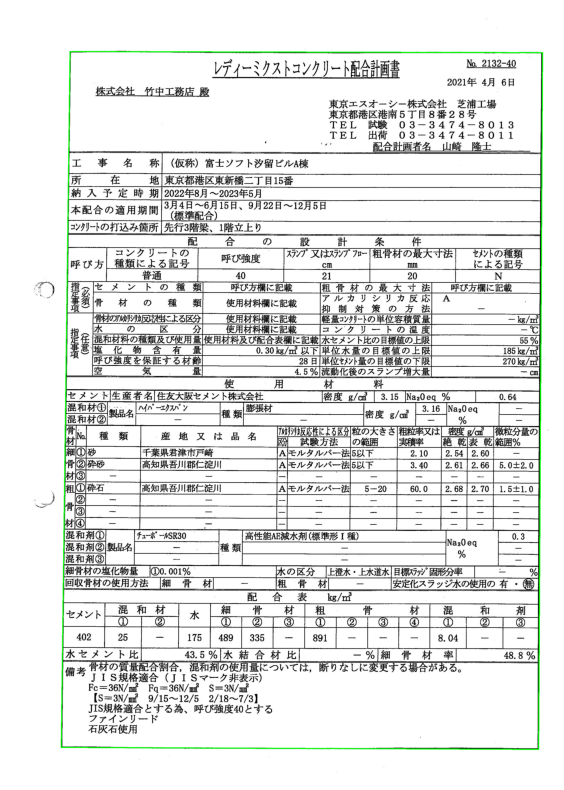

In [4]:
max_area = 0
contour_with_max_area = None
for contour in rectangular_contours:
    area = cv2.contourArea(contour)
    if area > max_area:
        max_area = area
        contour_with_max_area = contour

image_with_contour_with_max_area = image.copy()
cv2.drawContours(image_with_contour_with_max_area, [contour_with_max_area], -1, (0, 255, 0), 3)
plt.figure(figsize = (30,10))
plt.imshow(image_with_contour_with_max_area, cmap='gray')
plt.axis('off')
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12460\1158651274.py:6: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


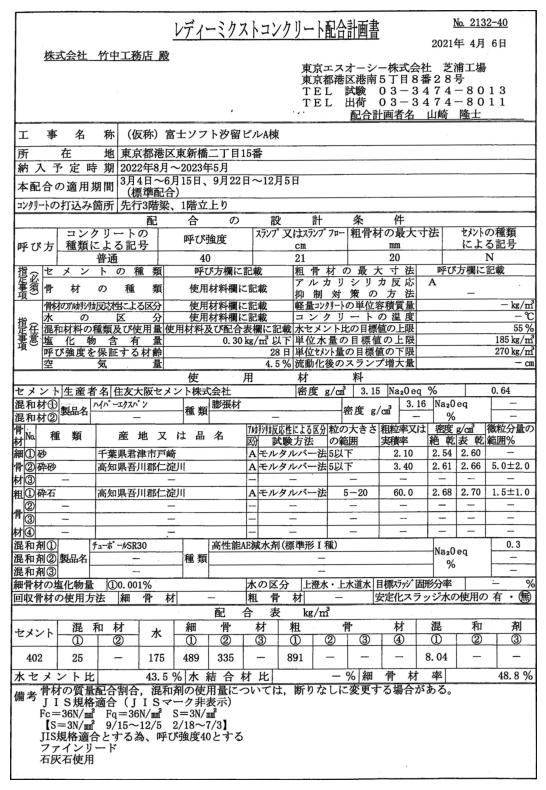

In [5]:
import numpy as np

# Tìm bounding box của contour lớn nhất
rect = cv2.minAreaRect(contour_with_max_area)
box = cv2.boxPoints(rect)
box = np.int0(box)

# Tính kích thước của bounding box
width = int(rect[1][0])
height = int(rect[1][1])

# Sắp xếp các điểm theo thứ tự (top-left, top-right, bottom-right, bottom-left)
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

box = order_points(box)

# Tạo ma trận biến đổi phối cảnh
dst_pts = np.array([
    [0, 0],
    [width-1, 0],
    [width-1, height-1],
    [0, height-1]
], dtype="float32")

M = cv2.getPerspectiveTransform(box, dst_pts)

# Áp dụng phép biến đổi phối cảnh để lấy hình ảnh mới chứa contour
warped = cv2.warpPerspective(image, M, (width, height))

# Hiển thị ảnh mới chứa contour
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


#### 2. Detection table structure ####

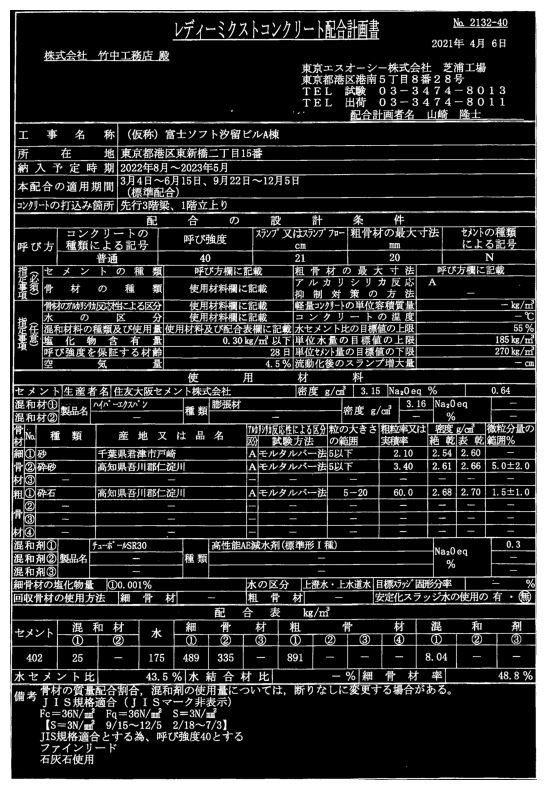

In [6]:
image_new = warped.copy()

# Chuyển ảnh sang xám
image_process = cv2.cvtColor(image_new, cv2.COLOR_BGR2GRAY)

# Thresholding
_, image_process = cv2.threshold(image_process, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Inverting
image_process = cv2.bitwise_not(image_process)

plt.figure(figsize=(10, 10))
plt.imshow(image_process, cmap='gray')
plt.axis('off')
plt.show()

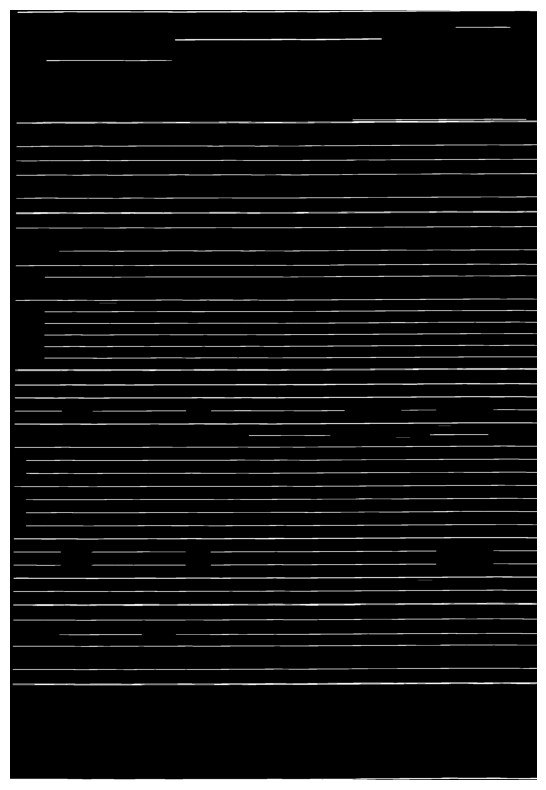

In [7]:
hor = np.array([[1,1,1,1,1,1]])
vertical_lines_eroded_image = cv2.erode(image_process, hor, iterations=10)
vertical_lines_eroded_image = cv2.dilate(vertical_lines_eroded_image, hor, iterations=10)

plt.figure(figsize=(10, 10))
plt.imshow(vertical_lines_eroded_image, cmap='gray')
plt.axis('off')
plt.show()

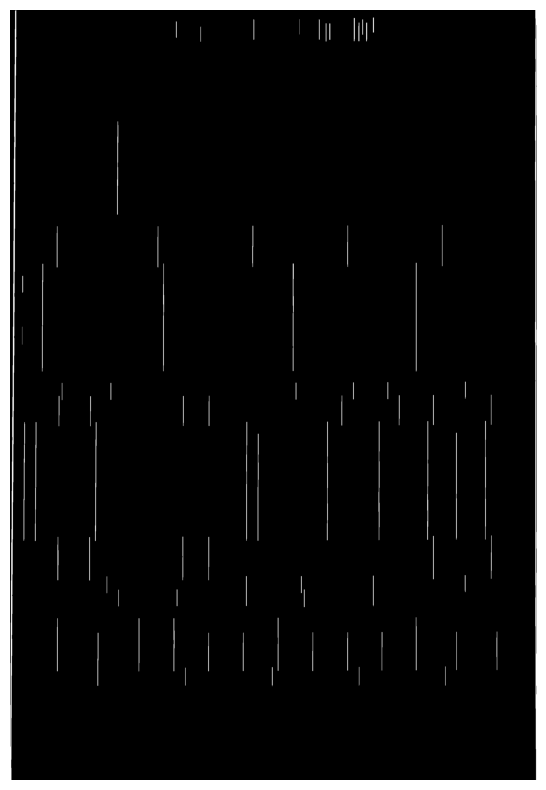

In [30]:
ver = np.array([[1],
            [1],
            [1],
            [1],
            [1],
            [1],
            [1]])
horizontal_lines_eroded_image = cv2.erode(image_process, ver, iterations=8)
horizontal_lines_eroded_image = cv2.dilate(horizontal_lines_eroded_image, ver, iterations=10)

plt.figure(figsize=(10, 10))
plt.imshow(horizontal_lines_eroded_image, cmap='gray')
plt.axis('off')
plt.show()

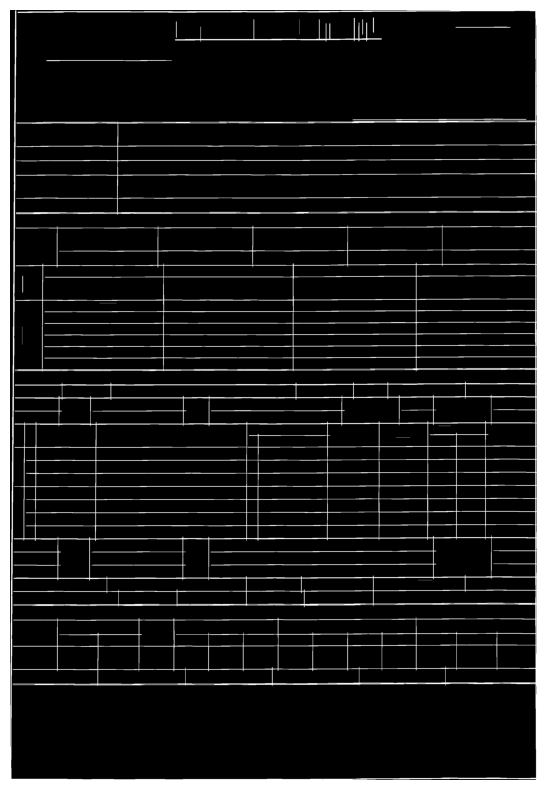

In [31]:
combined_image = cv2.add(vertical_lines_eroded_image, horizontal_lines_eroded_image)
plt.figure(figsize=(10, 10))
plt.imshow(combined_image, cmap='gray')
plt.axis('off')
plt.show()

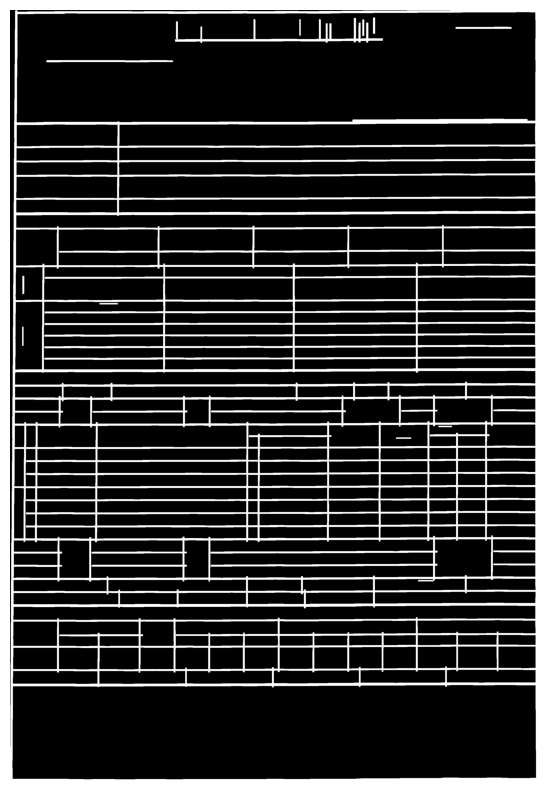

In [32]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
combined_image_dilated = cv2.dilate(combined_image, kernel, iterations=5)
plt.figure(figsize=(10, 10))
plt.imshow(combined_image_dilated, cmap='gray')
plt.axis('off')
plt.show()

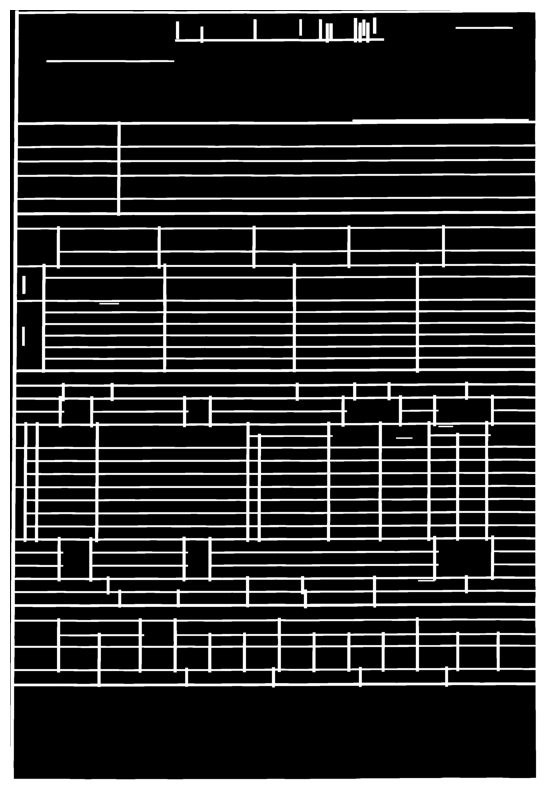

In [33]:
# Tạo ma trận dịch ảnh sang phải
rows, cols = combined_image_dilated.shape
translation_matrix = np.float32([[1, 0, 5], [0, 1, 0]])

# Dịch ảnh sang phải
shifted_image = cv2.warpAffine(combined_image_dilated, translation_matrix, (cols, rows))

# Kết hợp ảnh gốc và ảnh đã dịch
extended_image = cv2.bitwise_or(combined_image_dilated, shifted_image)

# Hiển thị ảnh kết quả
plt.figure(figsize=(10, 10))
plt.imshow(extended_image, cmap='gray')
plt.axis('off')
plt.show()

In [34]:
combined_image_dilated = extended_image.copy()

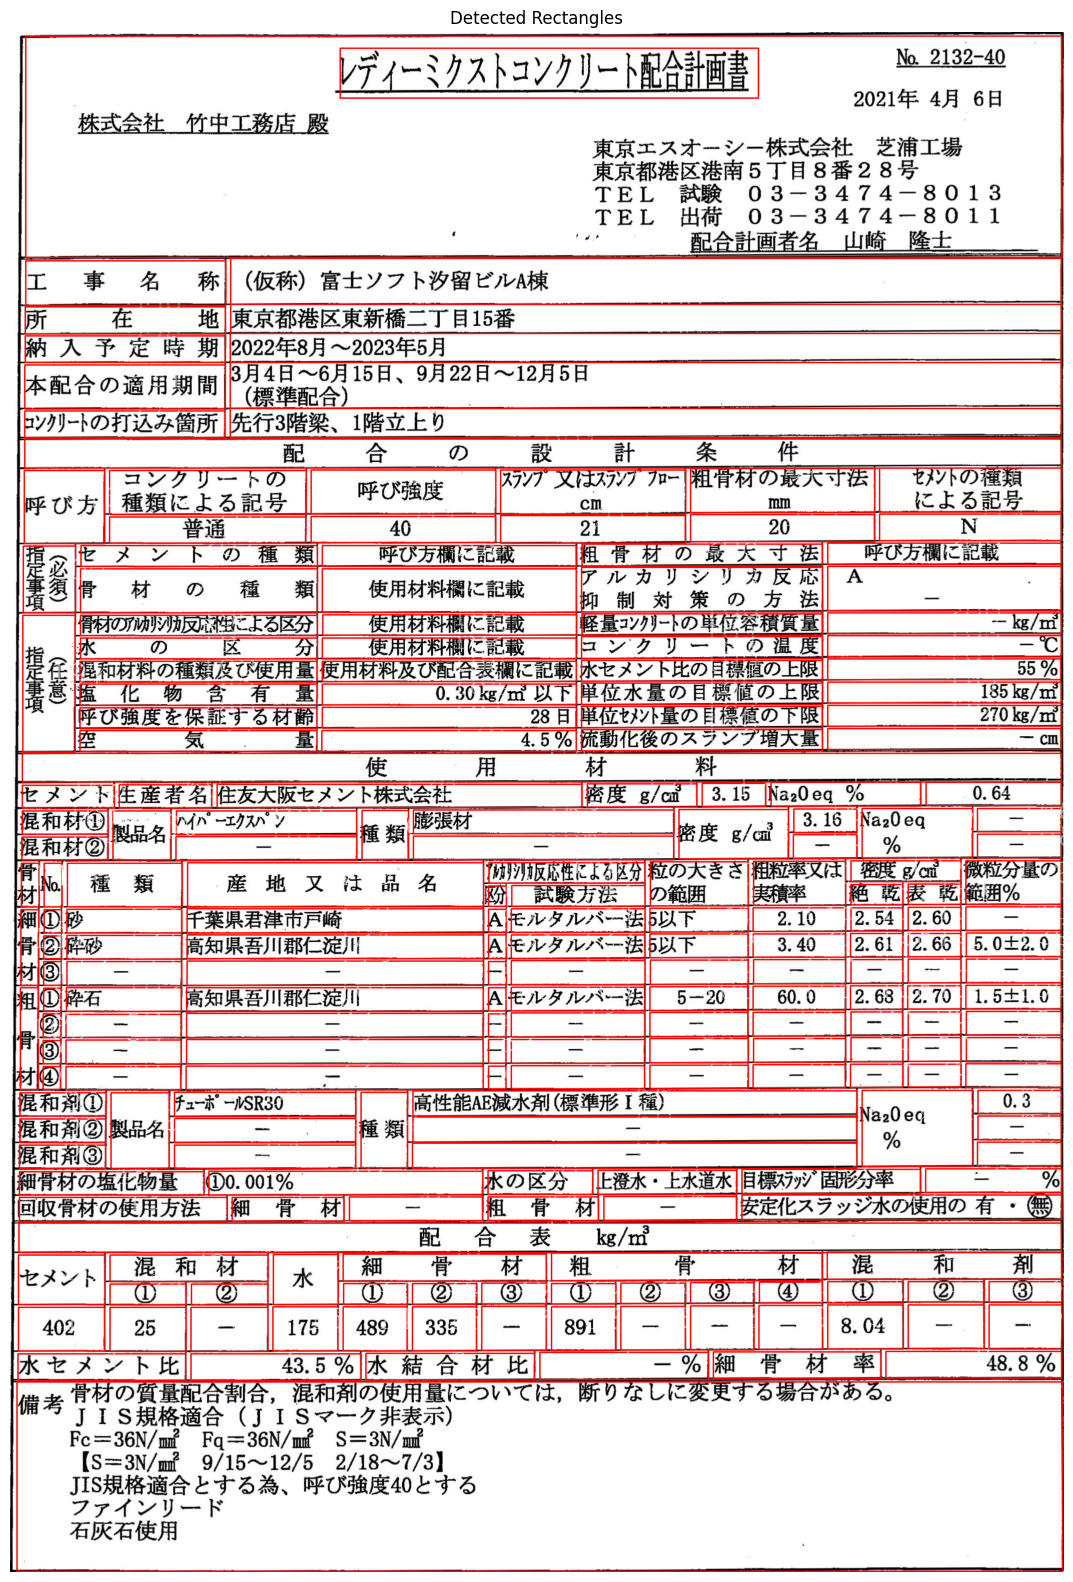

Detected Rectangles:
Rectangle 1: x=32, y=8, width=2138, height=457
Rectangle 2: x=14, y=2787, width=2158, height=391
Rectangle 3: x=454, y=682, width=1715, height=95
Rectangle 4: x=455, y=467, width=1714, height=95
Rectangle 5: x=18, y=2459, width=2151, height=61
Rectangle 6: x=30, y=840, width=2139, height=60
Rectangle 7: x=25, y=1489, width=2144, height=59
Rectangle 8: x=454, y=777, width=1715, height=60
Rectangle 9: x=454, y=622, width=1715, height=60
Rectangle 10: x=455, y=562, width=1714, height=60
Rectangle 11: x=681, y=33, width=863, height=103
Rectangle 12: x=366, y=1715, width=611, height=91
Rectangle 13: x=830, y=2294, width=917, height=52
Rectangle 14: x=831, y=2240, width=916, height=52
Rectangle 15: x=831, y=2186, width=916, height=52
Rectangle 16: x=644, y=1108, width=524, height=90
Rectangle 17: x=1179, y=1105, width=497, height=92
Rectangle 18: x=145, y=1108, width=489, height=91
Rectangle 19: x=1687, y=1103, width=482, height=92
Rectangle 20: x=32, y=472, width=413, h

In [35]:
# Tìm contours trong ảnh nhị phân
contours, _ = cv2.findContours(combined_image_dilated, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

line_image = warped.copy()
# Lặp qua từng contour để vẽ và trích xuất hình chữ nhật
rectangles = []
count = 0
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Lọc các hình chữ nhật có diện tích và tỷ lệ phù hợp
    area = cv2.contourArea(contour)
    if area > 1000 and w > 10 and h > 10 and h < line_image.shape[0]:
        count += 1
        rectangles.append((x, y, w, h))
        cv2.rectangle(line_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Vẽ bounding box màu đỏ
        cv2.putText(line_image, str(count), (int(x + w / 2), int(y + h / 2)), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=2, color=(255, 255, 255))

rectangles_sorted = sorted(rectangles, key=lambda rect: rect[2] * rect[3], reverse=True)

# Hiển thị ảnh với các bounding box đã vẽ
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Rectangles')
plt.show()

# In ra các hình chữ nhật trích xuất được
print("Detected Rectangles:")
for i, (x, y, w, h) in enumerate(rectangles_sorted, 1):
    print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")

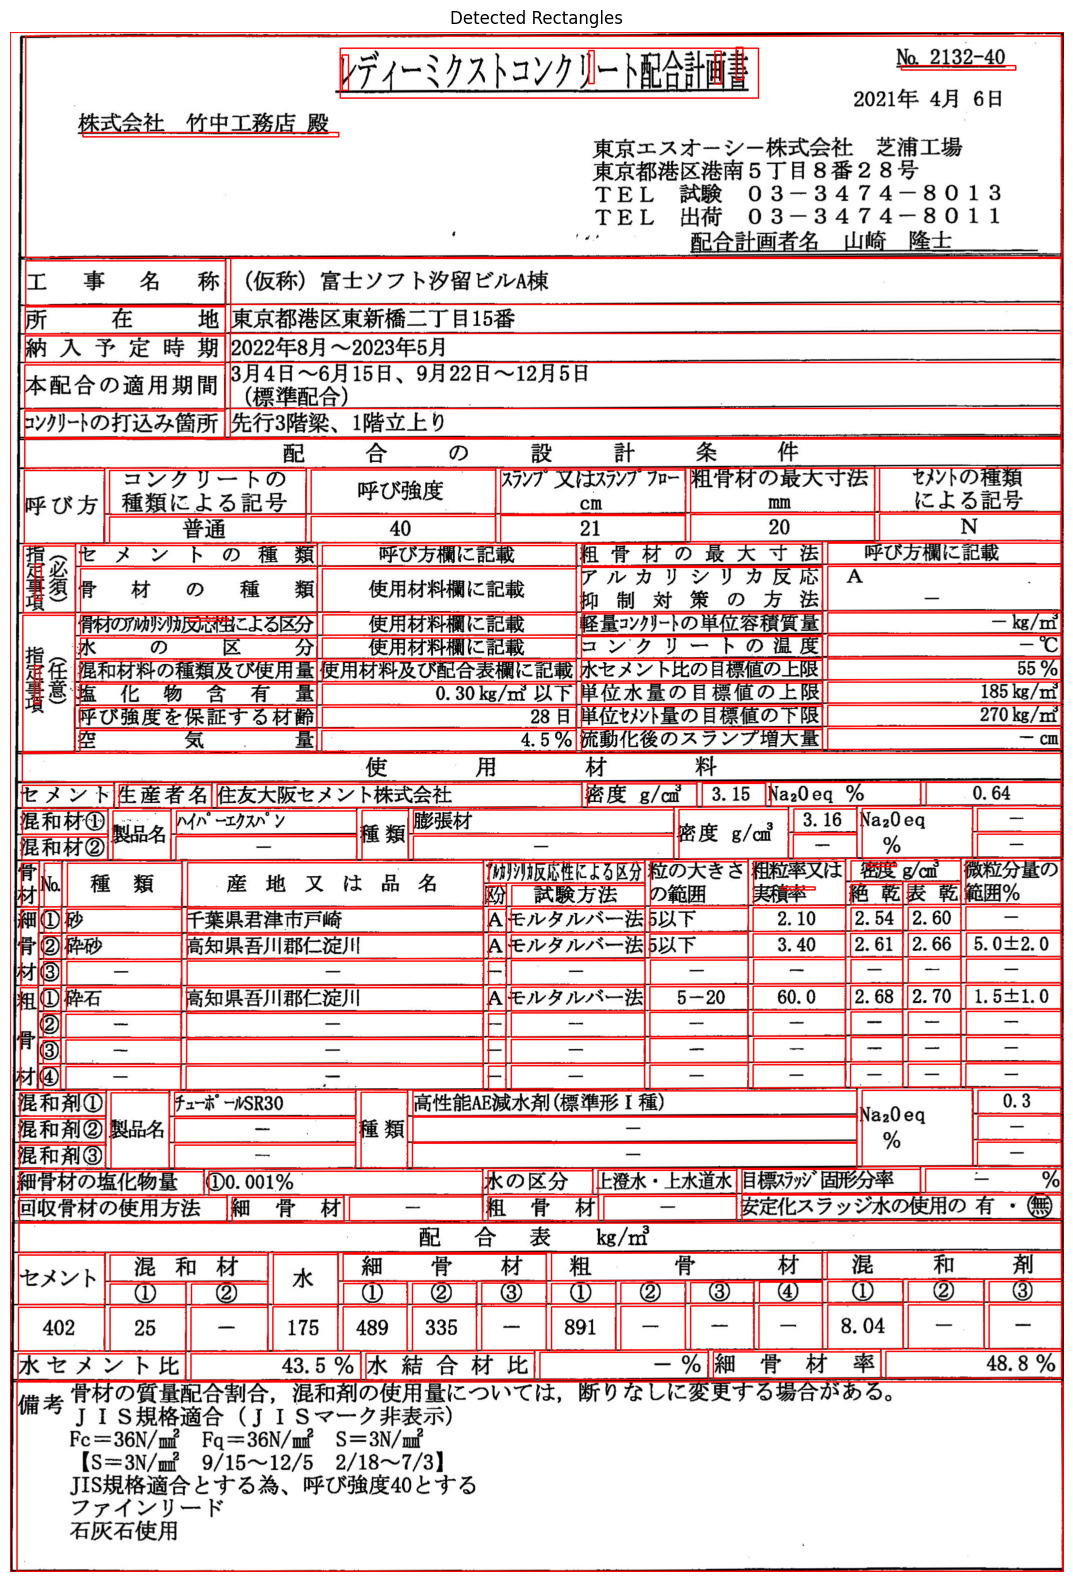

Detected Rectangles:
Rectangle 1: x=0, y=0, width=2175, height=3180
Rectangle 2: x=32, y=8, width=2138, height=457
Rectangle 3: x=14, y=2787, width=2158, height=391
Rectangle 4: x=454, y=682, width=1715, height=95
Rectangle 5: x=455, y=467, width=1714, height=95
Rectangle 6: x=18, y=2459, width=2151, height=61
Rectangle 7: x=30, y=840, width=2139, height=60
Rectangle 8: x=25, y=1489, width=2144, height=59
Rectangle 9: x=454, y=777, width=1715, height=60
Rectangle 10: x=454, y=622, width=1715, height=60
Rectangle 11: x=455, y=562, width=1714, height=60
Rectangle 12: x=681, y=33, width=863, height=103
Rectangle 13: x=366, y=1715, width=611, height=91
Rectangle 14: x=830, y=2294, width=917, height=52
Rectangle 15: x=831, y=2240, width=916, height=52
Rectangle 16: x=831, y=2186, width=916, height=52
Rectangle 17: x=644, y=1108, width=524, height=90
Rectangle 18: x=1179, y=1105, width=497, height=92
Rectangle 19: x=145, y=1108, width=489, height=91
Rectangle 20: x=1687, y=1103, width=482, h

In [36]:
# Tìm contours trong ảnh nhị phân
contours, _ = cv2.findContours(combined_image_dilated, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

line_image = warped.copy()
# Lặp qua từng contour để vẽ và trích xuất hình chữ nhật
rectangles = []
count = 0
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Lọc các hình chữ nhật có diện tích và tỷ lệ phù hợp
    area = cv2.contourArea(contour)
    rectangles.append((x, y, w, h))
    cv2.rectangle(line_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Vẽ bounding box màu đỏ

rectangles_sorted = sorted(rectangles, key=lambda rect: rect[2] * rect[3], reverse=True)

# Hiển thị ảnh với các bounding box đã vẽ
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Rectangles')
plt.show()

# In ra các hình chữ nhật trích xuất được
print("Detected Rectangles:")
for i, (x, y, w, h) in enumerate(rectangles_sorted, 1):
    print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")

Selected Rectangles:
Rectangle 1: x=1794, y=900, width=375, height=91
Rectangle 2: x=1404, y=901, width=380, height=91
Rectangle 3: x=1012, y=904, width=382, height=91
Rectangle 4: x=621, y=904, width=381, height=91
Rectangle 5: x=205, y=905, width=406, height=91
Percent Rectangles:
Percent Rectangles:
Rectangle 1: x=16, y=2729, width=346, height=55
Rectangle 2: x=1807, y=2724, width=363, height=55
Rectangle 3: x=1451, y=2725, width=346, height=55
Rectangle 4: x=1093, y=2726, width=348, height=56
Rectangle 5: x=734, y=2728, width=348, height=55
Rectangle 6: x=373, y=2729, width=351, height=55
x(max) = 2170, y(max) = 2784
Selected Rectangle: x=18, y=2459, width=2151, height=61
(32, 8, 2138, 457)
(30, 840, 2139, 60)


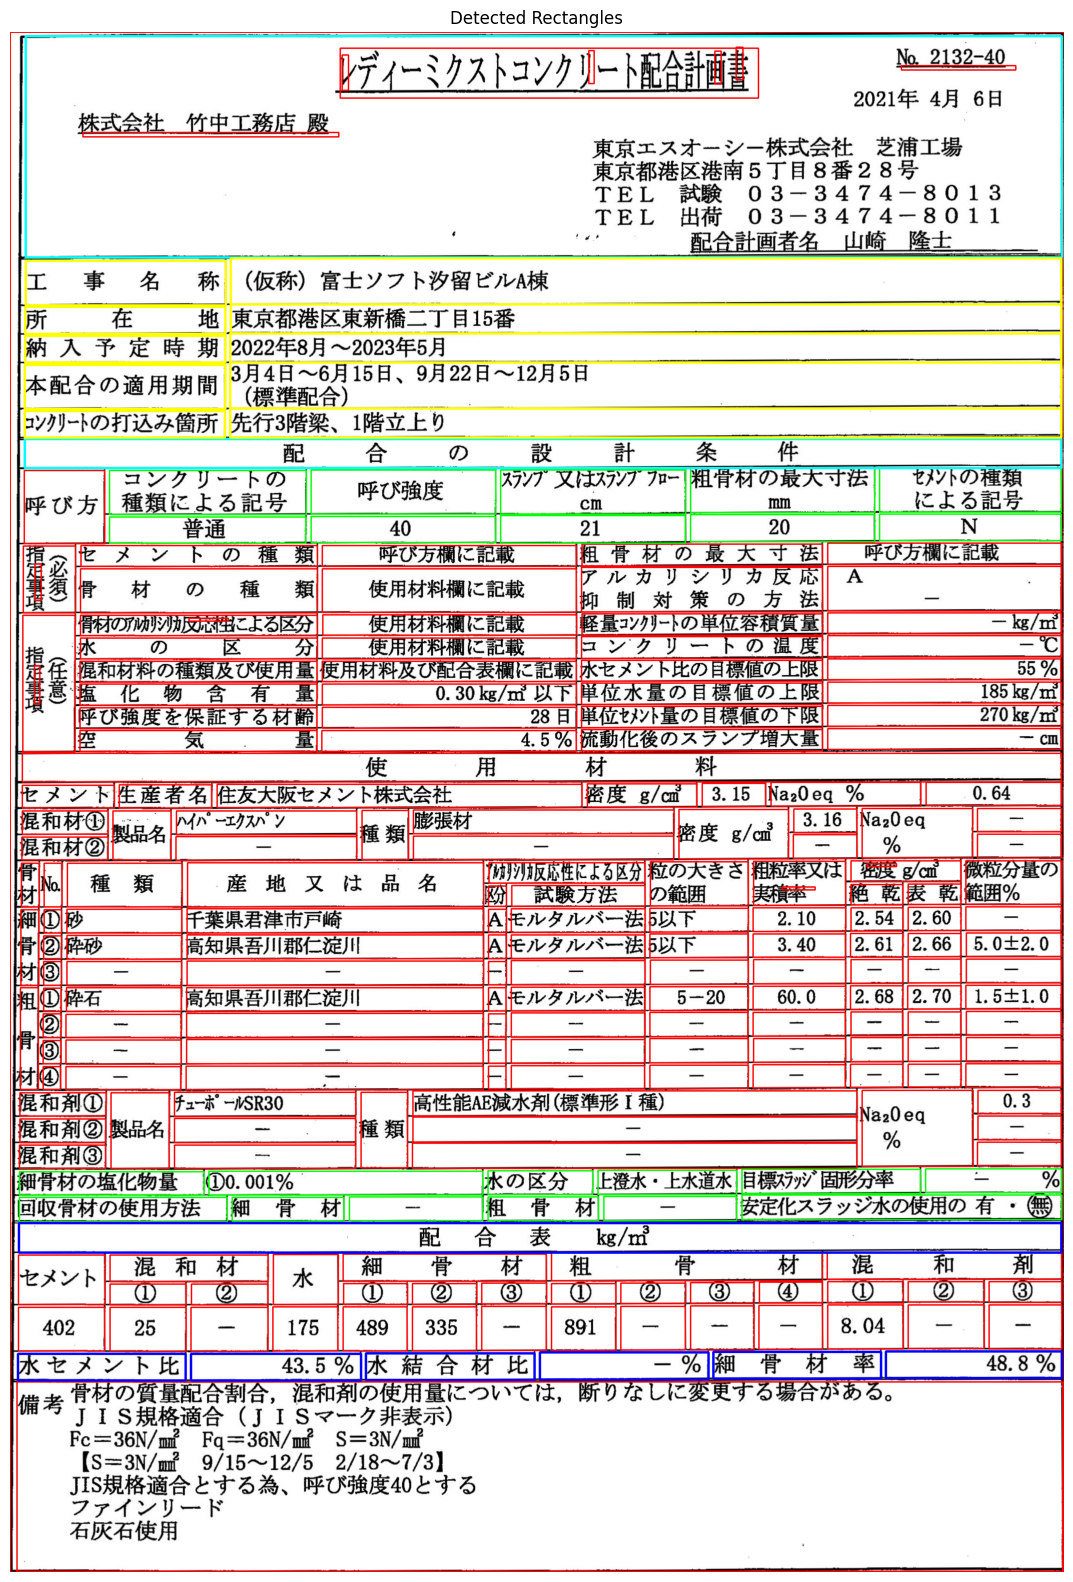

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Giả sử 'combined_image_dilated' là ảnh nhị phân chứa các đường ngang và dọc

# Tìm contours trong ảnh nhị phân
contours, _ = cv2.findContours(combined_image_dilated, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

line_image = warped.copy()
# Lặp qua từng contour để vẽ và trích xuất hình chữ nhật
rectangles = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Lọc các hình chữ nhật có diện tích và tỷ lệ phù hợp
    rectangles.append((x, y, w, h))
    cv2.rectangle(line_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Vẽ bounding box màu đỏ

# Sắp xếp các hình chữ nhật theo tọa độ y
rectangles_sorted = sorted(rectangles, key=lambda rect: rect[1])

# Tìm nhóm hình chữ nhật đứng cạnh nhau
def find_adjacent_rectangles(rectangles, max_y_diff=15, max_height_diff=15, min_width_ratio=0.7):
    groups = []
    groups_percent = []

    for i in range(len(rectangles)):
        group = [rectangles[i]]
        for j in range(len(rectangles)):
            if j != i:
                y_diff = abs(rectangles[j][1] - rectangles[i][1])
                height_diff = abs(rectangles[j][3] - rectangles[i][3])
                if y_diff < max_y_diff and height_diff < max_height_diff:
                    group.append(rectangles[j])
        if len(group) >= 5 and len(group) <= 6:
            groups.append(group)
        if len(group) == 6:
            groups_percent.append(group)
    return groups, groups_percent

adjacent_groups, groups_percent = find_adjacent_rectangles(rectangles_sorted)

# Tìm nhóm có tổng chiều dài chiếm phần lớn chiều dài hình ảnh
image_height, image_width = combined_image_dilated.shape
selected_groups = []
percent_group = []

for group in adjacent_groups:
    total_width = sum([w for (x, y, w, h) in group])
    if total_width > image_width * 0.8:
        selected_group = group
        selected_groups.append(selected_group)

for group in groups_percent:
    total_width = sum([w for (x, y, w, h) in group])
    if total_width > image_width * 0.95:
        percent_group = group

# Hiển thị ảnh với nhóm bounding box đã chọn
if selected_groups:
    for selected_group in selected_groups:
        for (x, y, w, h) in selected_group:
            cv2.rectangle(line_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Vẽ bounding box màu xanh lá

if percent_group:
    for (x, y, w, h) in percent_group:
        cv2.rectangle(line_image, (x, y), (x + w, y + h), (255, 0, 0), 4)  # Vẽ bounding box màu xanh duowng

# In ra các hình chữ nhật trích xuất được
print("Selected Rectangles:")
if selected_groups[0]:
    for i, (x, y, w, h) in enumerate(selected_groups[0], 1):
        print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")
else:
    print("No group of rectangles found that meets the criteria.")

# In ra các nhóm 6 hình chữ nhật chứa dữ liệu phần trăm
print("Percent Rectangles:")
# In ra tọa độ x(max) và y(max) của percent_group
x_max_2 = 0
y_max_2 = 0
if percent_group:
    x_max_2 = max(rect[0] + rect[2] for rect in percent_group)
    y_max_2 = max(rect[1] + rect[3] for rect in percent_group)
    
    print("Percent Rectangles:")
    for i, (x, y, w, h) in enumerate(percent_group, 1):
        print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")
    
    print(f"x(max) = {x_max_2}, y(max) = {y_max_2}")
else:
    print("No group of rectangles found that meets the criteria.")

# Xác định rectangle chứa đầu mục yêu cầu thứ hai
threshold_width = 0.9 * image_width

# Duyệt ngược mảng rectangles_sorted để tìm hình chữ nhật thỏa mãn điều kiện
selected_rectangle = None
for rect in reversed(rectangles_sorted):
    x, y, w, h = rect
    if y < y_max_2 and w > threshold_width:
        selected_rectangle = rect
        break
x_min_2 = 0
y_min_2 = 0
if selected_rectangle:
    x_min_2, y_min_2, w, h = selected_rectangle
    print(f"Selected Rectangle: x={x_min_2}, y={y_min_2}, width={w}, height={h}")
    cv2.rectangle(line_image, (x_min_2, y_min_2), (x_min_2 + w, y_min_2 + h), (255, 0, 0), 4) 

else:
    print("No rectangle found that meets the criteria.")


## Xây dựng việc tìm kiếm vùng nội dung thứ 3 (được kẹp giữa hai dùng chiếm gần hết chiều dài bức ảnh)
selected_rectangle_1 = None
selected_rectangle_2 = None
count = 1
for rect in rectangles_sorted:
    x, y, w, h = rect
    if w > threshold_width and h < image_height * 0.3 and count == 1:
        selected_rectangle_1 = rect
        cv2.rectangle(line_image, (x, y), (x + w, y + h), (255, 255, 0), 4) 
        print(selected_rectangle_1)
        count += 1
    else:
        if w > threshold_width and h < image_height * 0.3 and count == 2:
            selected_rectangle_2 = rect
            cv2.rectangle(line_image, (x, y), (x + w, y + h), (255, 255, 0), 4) 
            print(selected_rectangle_2)
            break

y_min_3 = selected_rectangle_1[1] + selected_rectangle_1[3] - 10
y_max_3 = selected_rectangle_2[1] + 10

info_row_group = []
for rect in rectangles_sorted:
    if rect[1] > y_min_3 and rect[1] < y_max_3:
        info_row_group.append(rect)
        cv2.rectangle(line_image, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 255), 4)
    if len(info_row_group) >= 10:
        break

# Xây dựng tìm kiếm vùng nội dung thứ 4 (vùng chứa trong thành phần nằm ở đầu của trang)
result_area_4 = selected_rectangle_1

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Rectangles')
plt.show()


#### Lấy yêu cầu truy xuất dữ liệu thứ nhất ####

In [38]:
result_group_0 = []
result_group_1 = []

print("Selected Rectangles Group 0:")
if selected_groups[0]:
    result_group_0 = selected_groups[0]
    result_group_0 = sorted(result_group_0, key=lambda rect: rect[0])

    for i, (x, y, w, h) in enumerate(result_group_0, 1):
        print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")
else:
    print("No group of rectangles found that meets the criteria.")

print("Selected Rectangles Group 1:")
if selected_groups[len(selected_groups[0])]:
    result_group_1 = selected_groups[len(selected_groups[0])]
    result_group_1 = sorted(result_group_1, key=lambda rect: rect[0])

    for i, (x, y, w, h) in enumerate(result_group_1, 1):
        print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")
else:
    print("No group of rectangles found that meets the criteria.")

Selected Rectangles Group 0:
Rectangle 1: x=205, y=905, width=406, height=91
Rectangle 2: x=621, y=904, width=381, height=91
Rectangle 3: x=1012, y=904, width=382, height=91
Rectangle 4: x=1404, y=901, width=380, height=91
Rectangle 5: x=1794, y=900, width=375, height=91
Selected Rectangles Group 1:
Rectangle 1: x=205, y=1001, width=405, height=54
Rectangle 2: x=621, y=1000, width=381, height=54
Rectangle 3: x=1012, y=998, width=381, height=57
Rectangle 4: x=1404, y=996, width=380, height=56
Rectangle 5: x=1794, y=995, width=375, height=55


190 2184 890 1055


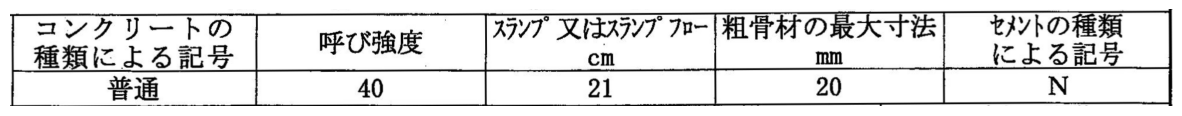

In [39]:
x_min_1 = min(rect[0] for rect in result_group_0)
y_min_1 = min(rect[1] for rect in result_group_0)

x_max_1 = max(rect[0] + rect[2] for rect in result_group_1)
y_max_1 = max(rect[1] + rect[3] for rect in result_group_1)

y_min_1 -= 10
y_max_1 += 0
x_min_1 -= 15
x_max_1 += 15
print(x_min_1, x_max_1, y_min_1, y_max_1)

image_result_1 = warped[y_min_1:y_max_1, x_min_1:x_max_1]

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(image_result_1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [40]:
from paddleocr import PaddleOCR

ocr = PaddleOCR(use_angle_cls=True, lang='japan')

if result_group_0:
    for i, (x, y, w, h) in enumerate(result_group_0, 1):
        image_crop = warped[y:y+h, x:x+w]
    
        # Đổi định dạng màu từ BGR sang RGB để phù hợp với PaddleOCR
        image_rgb = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
        
        # Nhận dạng văn bản từ hình ảnh cắt được
        result = ocr.ocr(image_rgb, cls=True)
        
        # Lưu kết quả nhận dạng vào file text
        result_text = ''
        for idx in range(len(result)):
            res = result[idx]
            for line in res:
                result_text += line[1][0] + '\n'
        print(f'Column {i}: \n {result_text}')

if result_group_1:
    for i, (x, y, w, h) in enumerate(result_group_1, 1):
        image_crop = warped[y:y+h, x:x+w]
    
        # Đổi định dạng màu từ BGR sang RGB để phù hợp với PaddleOCR
        image_rgb = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
        
        # Nhận dạng văn bản từ hình ảnh cắt được
        result = ocr.ocr(image_rgb, cls=True)
        
        # Lưu kết quả nhận dạng vào file text
        result_text = ''
        for idx in range(len(result)):
            res = result[idx]
            for line in res:
                result_text += line[1][0] + '\n'
        print(f'Column {i}: \n {result_text}')

[2024/07/24 09:53:16] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\japan\\japan_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320'

#### Lấy yêu cầu truy xuất dữ liệu thứ 2 ####

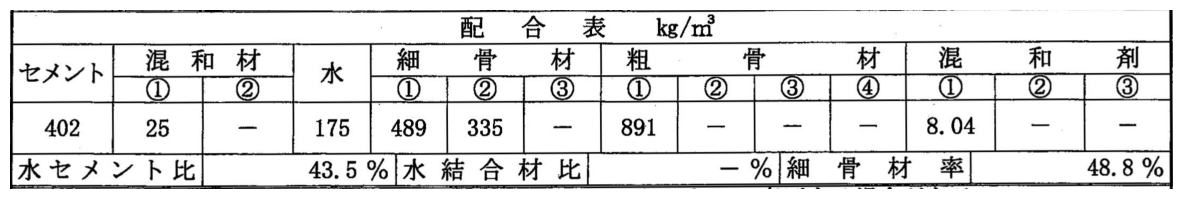

In [41]:
y_min_2 -= 5
y_max_2 += 5
x_min_2 -= 15
x_max_2 += 15
image_result_2 = warped[y_min_2:y_max_2, x_min_2:x_max_2]

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(image_result_2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

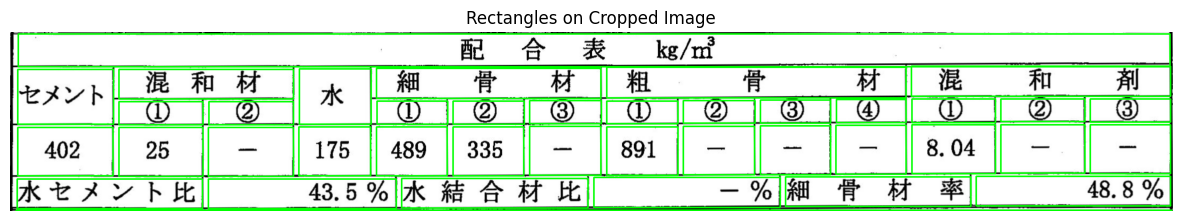

In [42]:
adjusted_rectangles = []
for rect in rectangles_sorted:
    x, y, w, h = rect
    if x_min_2 <= x <= x_max_2 and y_min_2 <= y <= y_max_2:
        adjusted_rect = (x - x_min_2, y - y_min_2, w, h)
        adjusted_rectangles.append(adjusted_rect)

# Vẽ các hình chữ nhật lên image_result_2
image_result_2_copy = image_result_2.copy()
for (x, y, w, h) in adjusted_rectangles:
    cv2.rectangle(image_result_2_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Màu xanh lá

# Hiển thị ảnh kết quả
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(image_result_2_copy, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Rectangles on Cropped Image')
plt.show()

Grouped Rectangles by Rows:
Row 1:
  Rectangle 1: x=15, y=5, width=2151, height=61
Row 2:
  Rectangle 1: x=14, y=71, width=179, height=102
  Rectangle 2: x=203, y=71, width=326, height=55
  Rectangle 3: x=540, y=70, width=134, height=103
  Rectangle 4: x=684, y=69, width=419, height=56
  Rectangle 5: x=1114, y=67, width=559, height=57
  Rectangle 6: x=1683, y=65, width=484, height=56
Row 3:
  Rectangle 1: x=203, y=131, width=157, height=43
  Rectangle 2: x=371, y=131, width=158, height=43
  Rectangle 3: x=685, y=130, width=132, height=43
  Rectangle 4: x=827, y=130, width=133, height=43
  Rectangle 5: x=970, y=129, width=134, height=43
  Rectangle 6: x=1114, y=130, width=133, height=42
  Rectangle 7: x=1257, y=129, width=134, height=42
  Rectangle 8: x=1401, y=128, width=131, height=43
  Rectangle 9: x=1543, y=127, width=130, height=43
  Rectangle 10: x=1684, y=126, width=156, height=44
  Rectangle 11: x=1850, y=126, width=157, height=42
  Rectangle 12: x=2017, y=126, width=150, height

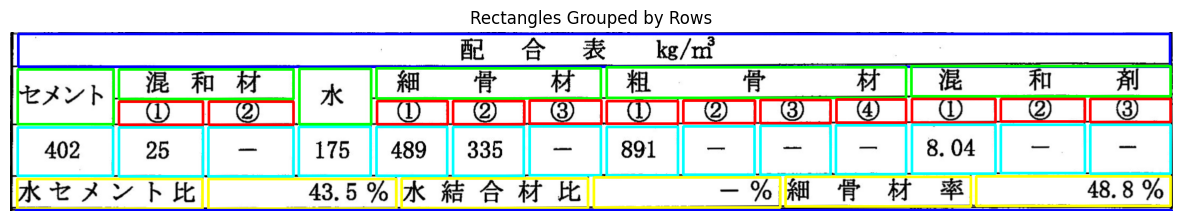

In [43]:
# Nhóm các hình chữ nhật theo hàng
def group_rectangles_by_rows(rectangles, row_threshold=10):
    rows = []
    rectangles_sorted_by_y = sorted(rectangles, key=lambda r: r[1])
    current_row = []

    for rect in rectangles_sorted_by_y:
        if not current_row:
            current_row.append(rect)
        else:
            _, y, _, _ = rect
            _, current_y, _, _ = current_row[-1]
            if abs(y - current_y) <= row_threshold:
                current_row.append(rect)
            else:
                rows.append(current_row)
                current_row = [rect]

    if current_row:
        rows.append(current_row)

    # Sắp xếp các hình chữ nhật trong mỗi hàng theo tọa độ x
    for row in rows:
        row.sort(key=lambda r: r[0])

    return rows

rows_of_rectangles = group_rectangles_by_rows(adjusted_rectangles)

# Hiển thị kết quả
print("Grouped Rectangles by Rows:")
for i, row in enumerate(rows_of_rectangles, 1):
    print(f"Row {i}:")
    for indx, rect in enumerate(row, 1):
        x, y, w, h = rect
        print(f"  Rectangle {indx}: x={x}, y={y}, width={w}, height={h}")

# Vẽ các hình chữ nhật theo hàng lên image_result_2
image_result_with_rows = image_result_2.copy()
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]  # Các màu khác nhau cho các hàng

for row_idx, row in enumerate(rows_of_rectangles):
    color = colors[row_idx % len(colors)]
    for (x, y, w, h) in row:
        cv2.rectangle(image_result_with_rows, (x, y), (x + w, y + h), color, 4)

# Hiển thị ảnh kết quả
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(image_result_with_rows, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Rectangles Grouped by Rows')
plt.show()


In [53]:
def getTextOCR(rectangle_groups, language):
    result_texts = []

    ocr = PaddleOCR(use_angle_cls=True, lang=language)
    if rectangle_groups:
        for i, (x, y, w, h) in enumerate(rectangle_groups, 1):
            image_crop = image_result_2[y:y+h, x:x+w]
            
            # Đổi định dạng màu từ BGR sang RGB để phù hợp với PaddleOCR
            image_rgb = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
                
            # Nhận dạng văn bản từ hình ảnh cắt được
            result = ocr.ocr(image_rgb, cls=True)
                
            # Lưu kết quả nhận dạng vào file text
            result_text = ''
            for idx in range(len(result)):
                res = result[idx]
                if res:
                    for line in res:
                        result_text += line[1][0] + ' '
            result_texts.append(result_text)
    
    return result_texts

In [54]:
def count_sequences_with_same_start(array):
    result = []
    count = 1
    for i in range(1, len(array)):
        # So sánh 3 từ đầu của 2 chuỗi hiện tại và trước đó
        if array[i][:3] == array[i-1][:3]:
            count += 1
        else:
            result.append(count)
            count = 1
    
    # Ghi nhận số lượng từ liên tiếp cuối cùng
    result.append(count)
    
    return result

In [55]:
result_2_info_1_head = []
result_2_info_1 = []
result_2_info_2 = []

result_numbers = []
array_number_full = [1, 2, 1, 4, 4, 3]


if len(rows_of_rectangles) >= 4:
    if len(rows_of_rectangles[1]) > 6:
        result_2_info_1_head = rows_of_rectangles[1]
        result_2_info_1 = rows_of_rectangles[2]
        result_2_info_2 = rows_of_rectangles[3]

        # Xử lý dữ liệu lấy thông tin của 14 trường tham số: 1-2-1-4-3-3   <<== 1-2-1-3-3-3
        head_texts = getTextOCR(result_2_info_1_head, 'japan')
        value_texts = getTextOCR(result_2_info_1, 'en')
        array_number = count_sequences_with_same_start(head_texts)

        count = 0
        for indx, number in enumerate(array_number):
            for i in range(number):
                result_numbers.append(value_texts[count])
                count += 1
            if number < array_number_full[indx]:
                for i in range(array_number_full[indx] - number):
                    result_numbers.append('')
        
        print(result_numbers)
        

    else:
        if len(rows_of_rectangles[1]) == 6:
            result_2_info_1_head = rows_of_rectangles[1]
            result_2_info_1 = rows_of_rectangles[3]
            result_2_info_2 = rows_of_rectangles[4]

            value_texts = getTextOCR(result_2_info_1, 'en')


            array_number = []
            for (x, y, w, h) in result_2_info_1_head:
                count = 0
                for (x_sub, y_sub, w_sub, h_sub) in rows_of_rectangles[2]:
                    if x - 10 < x_sub and x_sub < x + w + 10:
                        count += 1
                    if x_sub > x + w:
                        break
                if count == 0:
                    count += 1
                array_number.append(count)

            count = 0
            for indx, number in enumerate(array_number):
                for i in range(number):
                    result_numbers.append(value_texts[count])
                    count += 1
                if number < array_number_full[indx]:
                    for i in range(array_number_full[indx] - number):
                        result_numbers.append('')
            
            print(result_numbers)
            

                

[2024/07/24 13:12:12] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=

In [51]:
print(array_number)

[1, 2, 1, 3, 4, 3]


In [49]:
print(getTextOCR(result_2_info_1_head))

[2024/07/24 11:42:10] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\japan\\japan_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320'

In [46]:
from paddleocr import PaddleOCR

ocr = PaddleOCR(use_angle_cls=True, lang='en')

result_number_percent = []

if result_2_info_2:
    for i, (x, y, w, h) in enumerate(result_2_info_2, 1):
        if i % 2 == 0:
            image_crop = image_result_2[y:y+h, x:x+w]
        
            # Đổi định dạng màu từ BGR sang RGB để phù hợp với PaddleOCR
            image_rgb = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
            
            # Nhận dạng văn bản từ hình ảnh cắt được
            result = ocr.ocr(image_rgb, cls=True)
            
            # Lưu kết quả nhận dạng vào file text
            result_text = ''
            for idx in range(len(result)):
                res = result[idx]
                if res:
                    for line in res:
                        result_text += line[1][0] + ' '
            print(f'Column {i}: \n {result_text}')

            result_text = result_text[:-2]

            if result_text:
                try:
                    number = float(result_text)
                    result_number_percent.append(number)
                except ValueError:
                    result_number_percent.append('')
            else:
                result_number_percent.append('')

print('-----------------------------------------------')
print(result_number_percent)


[2024/07/24 10:22:55] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=

[2024/07/24 10:22:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12541866302490234
[2024/07/24 10:22:57] ppocr DEBUG: cls num  : 1, elapsed : 0.020000457763671875
[2024/07/24 10:22:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.13208770751953125
Column 2: 
 43.5 % 
[2024/07/24 10:22:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.021963834762573242
[2024/07/24 10:22:57] ppocr DEBUG: cls num  : 1, elapsed : 0.013999462127685547
[2024/07/24 10:22:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12952184677124023
Column 4: 
 - % 
[2024/07/24 10:22:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.026520252227783203
[2024/07/24 10:22:57] ppocr DEBUG: cls num  : 1, elapsed : 0.014993906021118164
[2024/07/24 10:22:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10552430152893066
Column 6: 
 48.8 % 
-----------------------------------------------
[43.5, '', 48.8]


#### Lấy yêu cầu thông tin từ nội dung thứ 3 ####

15 2174 457 837


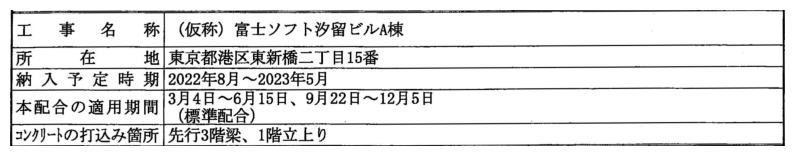

In [ ]:
x_min_3 = min(rect[0] for rect in info_row_group)
y_min_3 = min(rect[1] for rect in info_row_group)

x_max_3 = max(rect[0] + rect[2] for rect in info_row_group)
y_max_3 = max(rect[1] + rect[3] for rect in info_row_group)

y_min_3 -= 10
y_max_3 += 0
x_min_3 -= 15
x_max_3 += 5
print(x_min_3, x_max_3, y_min_3, y_max_3)

image_result_3 = warped[y_min_3:y_max_3, x_min_3:x_max_3]

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(image_result_3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
from paddleocr import PaddleOCR

ocr = PaddleOCR(use_angle_cls=True, lang='japan')

if info_row_group:
    for i, (x, y, w, h) in enumerate(info_row_group, 1):
        if i % 2 == 1: 
            image_crop = warped[y:y+h, x:x+w]
        
            # Đổi định dạng màu từ BGR sang RGB để phù hợp với PaddleOCR
            image_rgb = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
            
            # Nhận dạng văn bản từ hình ảnh cắt được
            result = ocr.ocr(image_rgb, cls=True)
            
            # Lưu kết quả nhận dạng vào file text
            result_text = ''
            for idx in range(len(result)):
                res = result[idx]
                for line in res:
                    result_text += line[1][0] + ' '
            print(f'Column {i}: \n {result_text}')

[2024/07/24 01:16:46] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\japan\\japan_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320'

#### Lấy thông tin vùng dữ liệu yêu cầu thứ 4 ####

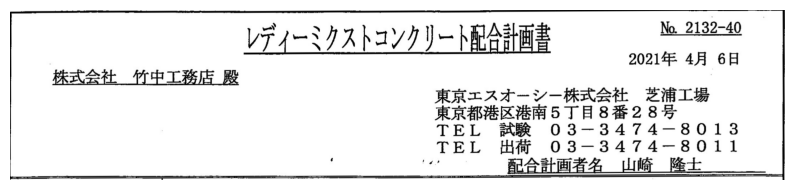

In [62]:
x, y, w, h = result_area_4
area_image_4 = warped[y-8:y+h+8, x-10:x+w+10]

plt.figure(figsize=(10, 10))
plt.imshow(area_image_4)
plt.axis('off')
plt.show()

In [63]:
ocr = PaddleOCR(use_angle_cls=True, lang='japan')

result = ocr.ocr(area_image_4, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

[2024/07/24 13:32:10] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\japan\\japan_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320'

In [66]:
from paddleocr import PaddleOCR

# Khởi tạo PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='japan')

# Thực hiện OCR
result = ocr.ocr(area_image_4, cls=True)

# Hàm tính tọa độ y trung bình của một box
def get_average_y(box):
    return (box[0][1] + box[1][1] + box[2][1] + box[3][1]) / 4

# Hàm tính tọa độ x trung bình của một box
def get_average_x(box):
    return (box[0][0] + box[1][0] + box[2][0] + box[3][0]) / 4

# Sắp xếp các box theo y trung bình
result_sorted = []
for res in result:
    res_sorted = sorted(res, key=lambda x: get_average_y(x[0]))
    result_sorted.append(res_sorted)

# Nhóm các box vào cùng một hàng và sắp xếp theo x
def group_boxes_by_line_and_sort_x(sorted_boxes, y_threshold=10):
    lines = []
    current_line = [sorted_boxes[0]]
    for i in range(1, len(sorted_boxes)):
        current_y = get_average_y(sorted_boxes[i][0])
        prev_y = get_average_y(current_line[-1][0])
        if abs(current_y - prev_y) < y_threshold:
            current_line.append(sorted_boxes[i])
        else:
            # Sắp xếp các box trong hàng theo x trung bình
            current_line_sorted = sorted(current_line, key=lambda x: get_average_x(x[0]))
            lines.append(current_line_sorted)
            current_line = [sorted_boxes[i]]
    if current_line:
        current_line_sorted = sorted(current_line, key=lambda x: get_average_x(x[0]))
        lines.append(current_line_sorted)
    return lines

# Gộp các box theo từng hàng, sắp xếp theo x và in kết quả
info_company = []
for res_sorted in result_sorted:
    lines = group_boxes_by_line_and_sort_x(res_sorted)
    for line in lines:
        line_text = " ".join([word_info[1][0] for word_info in line])
        print(line_text)
        info_company.append(line_text)

print(info_company)


[2024/07/24 13:46:20] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\japan\\japan_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320'

In [69]:
print(info_company[-1][7:])

山崎　隆士
